<a href="https://colab.research.google.com/github/hrithikwel8/Rossmann_Sales_Prediction/blob/main/Vridhi_Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store
* #### PromoInterval1/2/3 - describes the occurance of the promo2 in the months of 'Jan,Apr,July,Oct'/'Feb,May,Aug,Nov'/'March,June,Sep,dec' respectively where 1= the occurance and 0= not occuring

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Capstone Project 2/'
store_data_df = pd.read_csv(path + 'Rossmann Stores Data.csv')
store_df = pd.read_csv(path + 'store.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### EDA
We have 2 data files. Let's explore what each data file contains.

In [ ]:
store_data_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


"store.csv" file contains information about store data. It contains details for 1115 stores, each store have a unique id number which is given in the 'Store' column. Type of store and its Assortment Level are also given in the dataset.


All businesses have competitions even drug stores have competition. To overcome this competitive environment a store can run promotions to attract more customers and that leads to more sales.


Details of competition and promotional also present in dataset.

In [ ]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


Let's look at missing values in the dataset.

In [ ]:
missing_values= store_df.isnull()

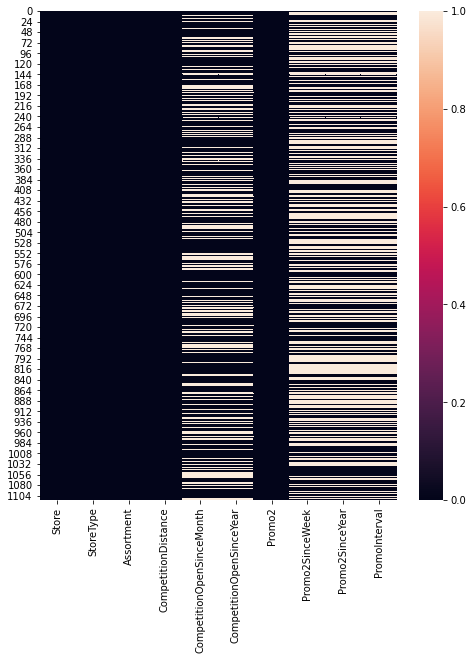

In [ ]:
#Heatmap of missing values in the store_df 
plt.figure(figsize=(8,9))
sns.heatmap(missing_values)

Most of missing values are from competition open time and promotion start time. If competition distance is large we don't need to worry about the competition as it will have less effect on store sales. We can fill all competition start time missing details as 0 for place holder which indicates no competition for the current store.

If store is not running promotion then we can set promotion start time as 0 as well.

In [ ]:
store_df['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [ ]:
store_df['CompetitionOpenSinceMonth'].fillna(0,inplace=True)

In [ ]:
store_df['CompetitionOpenSinceYear'].fillna(0,inplace=True)

In [ ]:
# this features shows NaN values for all the stores which doesnt run promos and hence we sustitute the value of Nan to 0
store_df['Promo2SinceWeek'].fillna(0,inplace=True)
store_df['Promo2SinceYear'].fillna(0,inplace=True)

In [ ]:
store_df['CompetitionDistance'].fillna(0,inplace=True)

In [ ]:
store_df['PromoInterval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

'Promo2' is a continuous promotion that runs for a specific month. We can see that the promotion interval is given in 3 unique values. Each promotion runs for a month then it starts again after 2 months. Since we have unique values to deal with we can assign a binary variable for each value. we will add 1 for present and 0 for absent. Thus we can have 3 new features containing binary values for promotion interval time.

In [ ]:
# Converting Qualitative Values to Quantitative
def Promo_interval1(row):
  if (row['PromoInterval']== 'Jan,Apr,Jul,Oct'):
    val = 1
  else:
    val =0
  return val
def Promo_interval2(row):
  if (row['PromoInterval']== 'Feb,May,Aug,Nov'):
    val = 1
  else:
    val =0
  return val
def Promo_interval3(row):
  if (row['PromoInterval']== 'Mar,Jun,Sept,Dec'):
    val = 1
  else:
    val =0
  return val
def Store_type1(row):
  if (row['StoreType'] == 'a'):
    val = 1
  else:
    val = 0
  return val
def Store_type2(row):
  if (row['StoreType'] == 'b'):
    val = 1
  else:
    val = 0
  return val
def Store_type3(row):
  if (row['StoreType'] == 'c'):
    val = 1
  else:
    val = 0
  return val
def Store_type4(row):
  if (row['StoreType'] == 'd'):
    val = 1
  else:
    val = 0
  return val
def Assortment_level1(row):
  if (row['Assortment'] == 'a'):
    val = 1
  else:
    val = 0
  return val
def Assortment_level2(row):
  if (row['Assortment'] == 'b'):
    val = 1
  else:
    val = 0
  return val
def Assortment_level3(row):
  if (row['Assortment'] == 'c'):
    val = 1
  else:
    val = 0
  return val


'Assortment' column contains 3 unique values, we can assign numerical values to feed the data in a machine learning model.

'StoreType' column also contains 4 unique values that can be assigned numerical values.

In [ ]:
store_df['PromoInterval1']= store_df.apply(Promo_interval1,axis=1)
store_df['PromoInterval2']=store_df.apply(Promo_interval2,axis=1)
store_df['PromoInterval3']=store_df.apply(Promo_interval3,axis=1)
store_df['StoreType1'] = store_df.apply(Store_type1,axis=1)
store_df['StoreType2'] = store_df.apply(Store_type2,axis=1)
store_df['StoreType3'] = store_df.apply(Store_type3,axis=1)
store_df['StoreType4'] = store_df.apply(Store_type4,axis=1)
store_df['AssortmentLeve1'] = store_df.apply(Assortment_level1,axis=1)
store_df['AssortmentLeve2'] = store_df.apply(Assortment_level2,axis=1)
store_df['AssortmentLeve3'] = store_df.apply(Assortment_level3,axis=1)

In [ ]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,PromoInterval1,PromoInterval2,PromoInterval3,StoreType1,StoreType2,StoreType3,StoreType4,AssortmentLeve1,AssortmentLeve2,AssortmentLeve3
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,0,0,0,0,0,1,0,1,0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,1,0,0,0,1,0,0
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,1,0,0,0,1,0,0
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,NaN,0,0,0,0,0,1,0,0,0,1
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,NaN,0,0,0,1,0,0,0,1,0,0


In [ ]:
store_df.drop(labels='PromoInterval',axis=1,inplace=True)
store_df.drop(labels='StoreType',axis=1,inplace=True)
store_df.drop(labels='Assortment',axis=1,inplace=True)

We have cleaned the data set. Let's check how much correlation each variable have with each other.

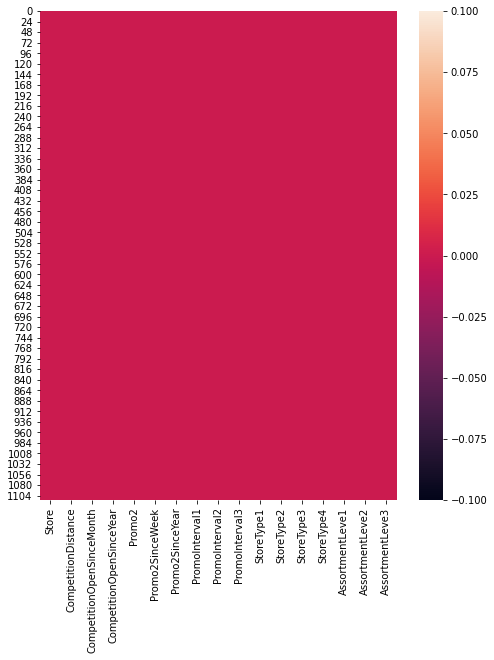

In [ ]:
# The heatmap after filling all the NaN values
final_na_df= store_df.isnull()
plt.figure(figsize=(8,9))
sns.heatmap(final_na_df)

In [ ]:
store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval1,PromoInterval2,PromoInterval3,StoreType1,StoreType2,StoreType3,StoreType4,AssortmentLeve1,AssortmentLeve2,AssortmentLeve3
count,1115.00000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000
mean,558.00000,5390.358744,4.930942,1370.939013,0.512108,12.083408,1030.239462,0.300448,0.116592,0.095067,0.539910,0.015247,0.132735,0.312108,0.531839,0.008072,0.460090
std,322.01708,7657.973705,4.284924,935.467654,0.500078,15.542241,1006.038782,0.458659,0.321077,0.293439,0.498628,0.122587,0.339441,0.463561,0.499209,0.089520,0.498628
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,279.50000,710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,558.00000,2320.000000,4.000000,2006.000000,1.000000,1.000000,2009.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,836.50000,6875.000000,9.000000,2011.000000,1.000000,22.000000,2012.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
n=['Store','CompetitionDistance','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval1','PromoInterval2','PromoInterval3','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','StoreType1','StoreType2','StoreType3','StoreType4','AssortmentLeve1','AssortmentLeve2','AssortmentLeve3']

In [ ]:
numeric_features= store_df[n]

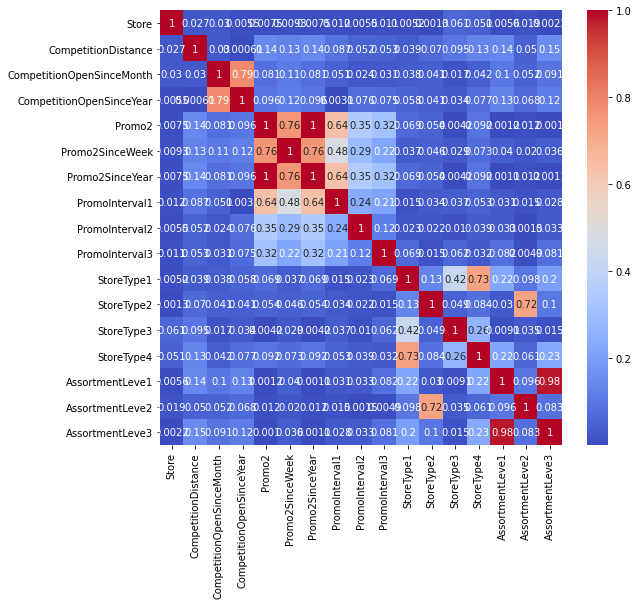

In [ ]:
plt.figure(figsize=(12,15))
correlation = store_df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

This dataset contains information about a particular day for all the stores. Date column contains information about the date on which data is collected.

This dataset contains our dependent variable 'Sales' which we need to predict. We have information about the number of customers that visited the store on the date.

Open column gives information if the store was open or closed on the date. We also have information about state holidays and school holidays.

Promo column contains information about a promotion offer running on a particular day. This is a special promotional offer that runs for only a given day.

We have information about competition start time, but how it is useful in the training linear regression model?

Model predictions work better if we provide data with continuous variables. So, how do we turn the competition start date into a continuous variable?

Well, we have the date of data collection, based on that we can calculate how many days have passed since the competition opened. Now this competition time is a continuous variable that we can use for model training.

In [ ]:
# removing the collinearity by converting to quantitative data of CompetitionOpenSinceYear and CompetitionOpenSinceMonth
def ApproxCompitionOpenSinceNumberOfDays(row):
  compitition_start_date= (row['CompetitionOpenSinceYear']*10000)+(row['CompetitionOpenSinceMonth']*100)+ 1
  competetion_time= row['new_date'] - compitition_start_date
  days= competetion_time % 100
  months= (competetion_time//100) % 100
  years= competetion_time//10000
  if months>12:
    months = (months + 12)%100
    years -=1
  total_time= years*365 + months*30 + days
  return total_time


In [ ]:
sales_df['CompitionOpenSinceNumberOfDays']=sales_df.apply(ApproxCompitionOpenSinceNumberOfDays,axis=1)
sales_df.drop(columns=['CompetitionOpenSinceYear','CompetitionOpenSinceMonth'],inplace=True)


In [ ]:
sales_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day,Sales_log_t,Customers_log_t,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompetitionTime
0,1,5,5263,555,1,1,1,0,0,0,2015,7,31,8.568646,6.320768,1270.0,3,1,0,2524
1,1,4,5020,546,1,1,1,0,0,0,2015,7,30,8.521384,6.304449,1270.0,3,1,0,2523
2,1,3,4782,523,1,1,1,0,0,0,2015,7,29,8.472823,6.261492,1270.0,3,1,0,2522
3,1,2,5011,560,1,1,1,0,0,0,2015,7,28,8.519590,6.329721,1270.0,3,1,0,2521
4,1,1,6102,612,1,1,1,0,0,0,2015,7,27,8.716536,6.418365,1270.0,3,1,0,2520


Text(0.5, 1.0, 'Correlation matrix')

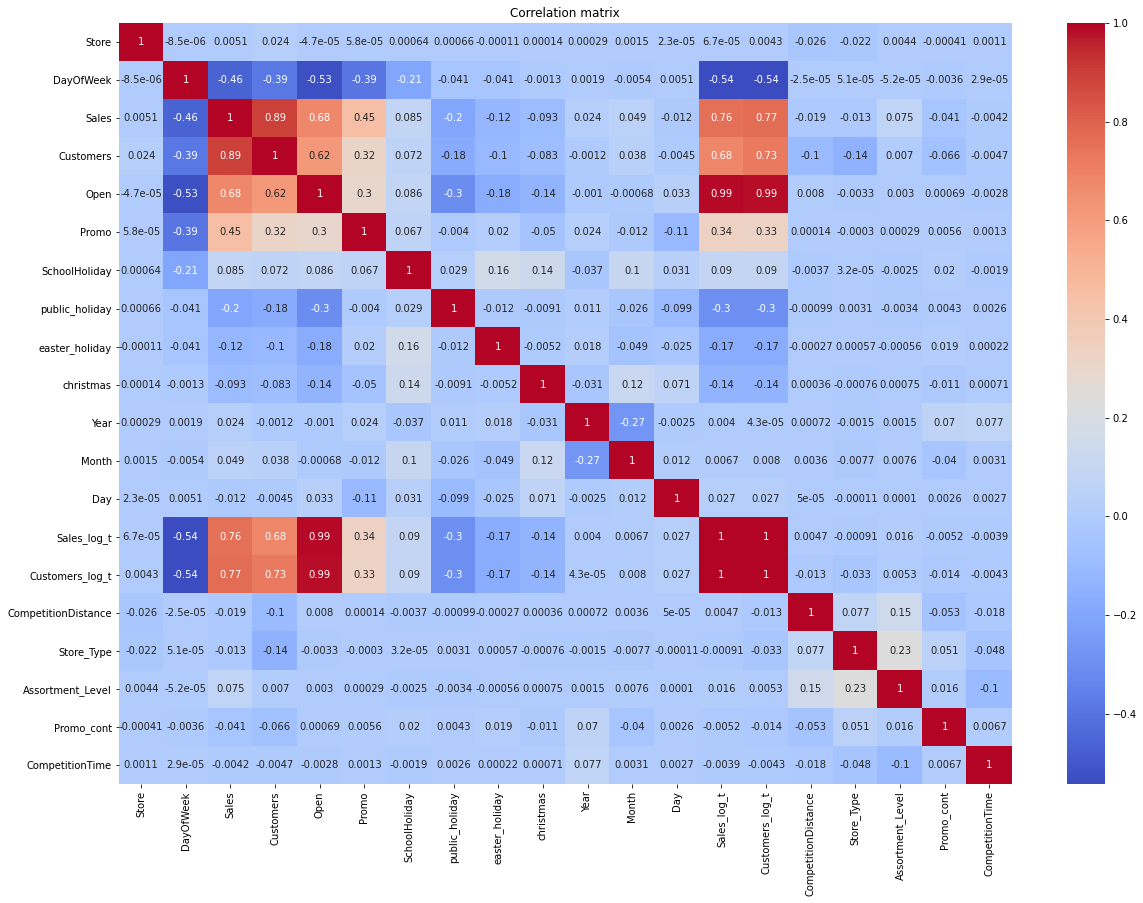

In [ ]:
# plot correlation matrix
plt.figure(figsize=(20,14))
sns.heatmap(sales_df.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation matrix')

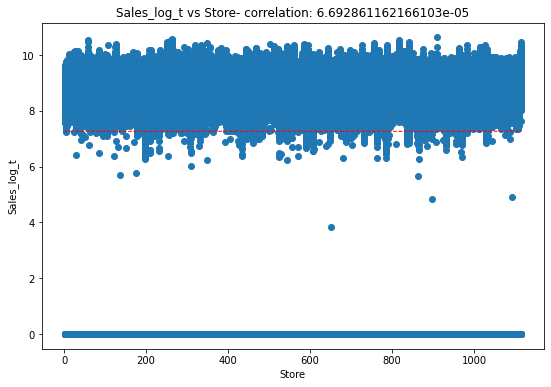

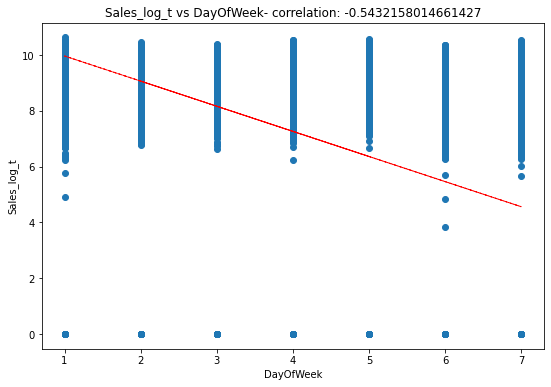

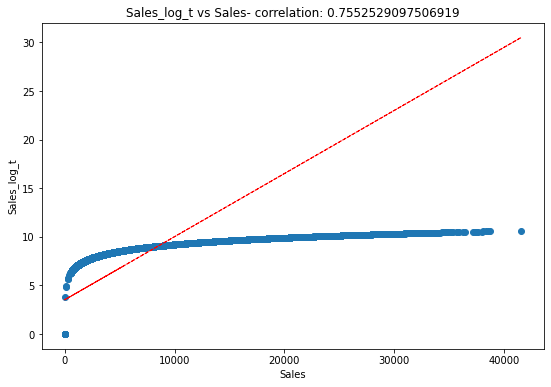

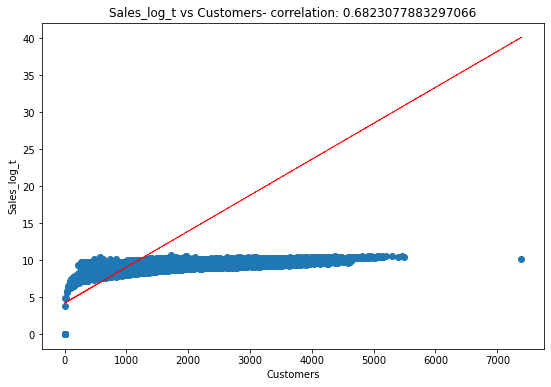

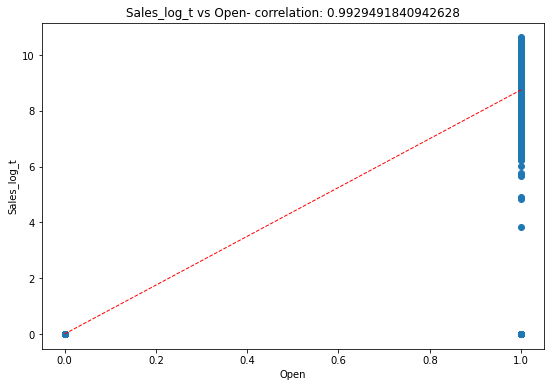

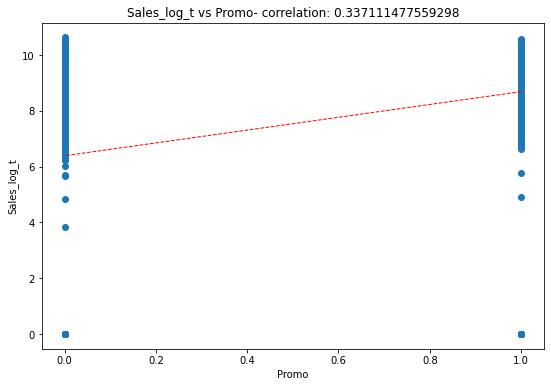

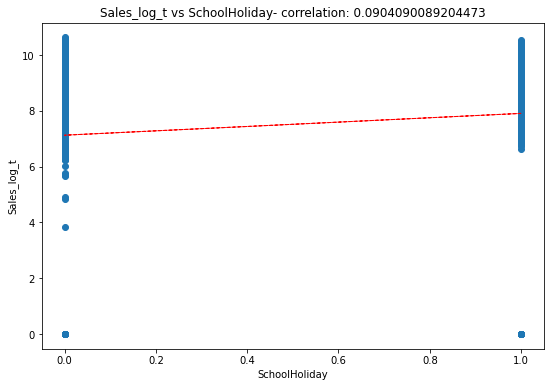

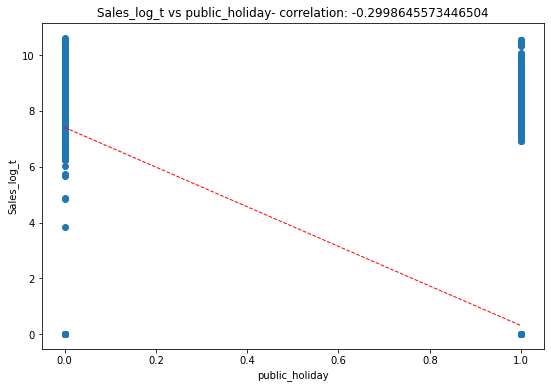

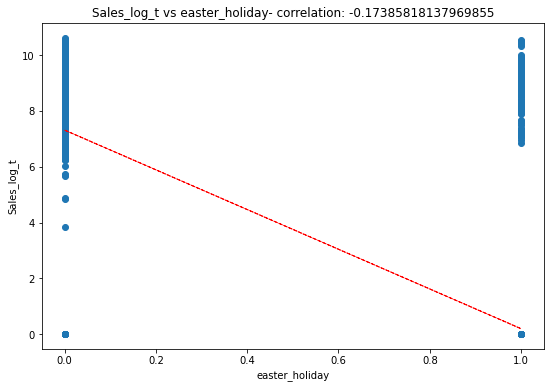

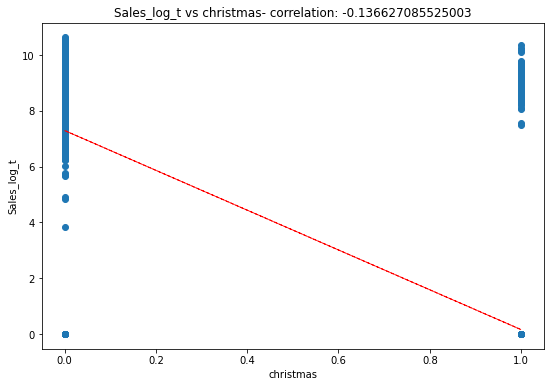

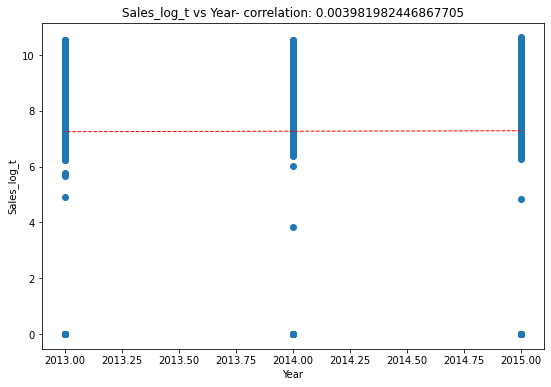

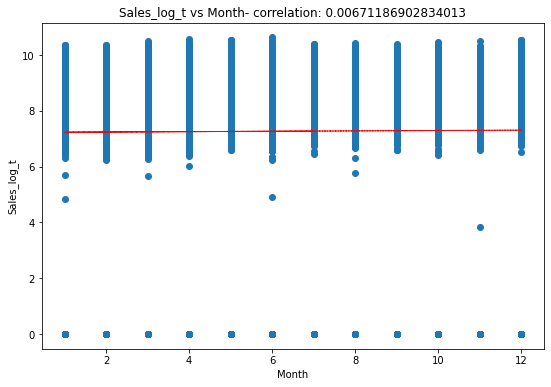

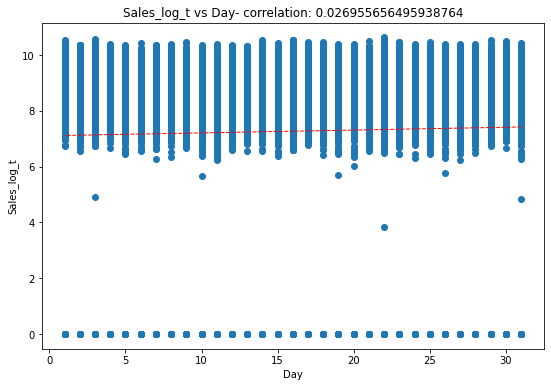

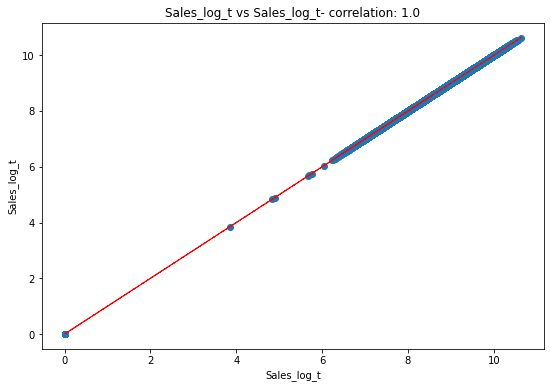

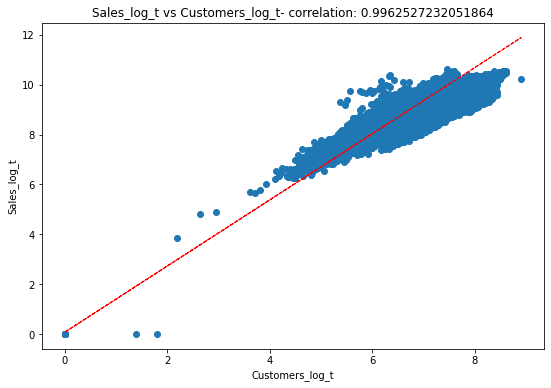

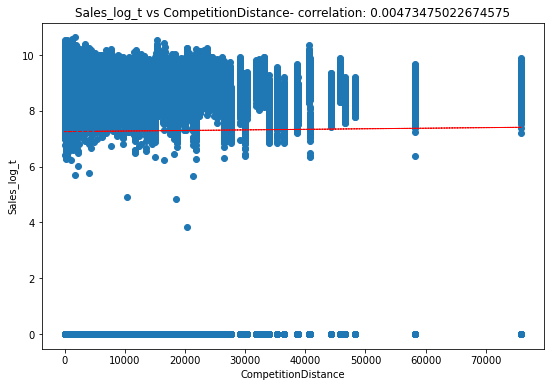

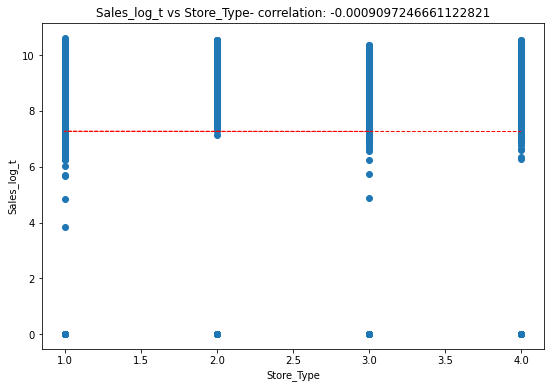

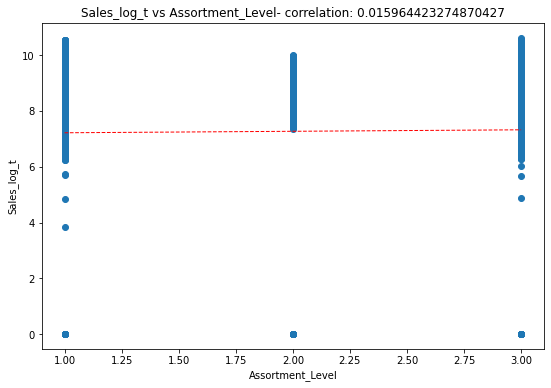

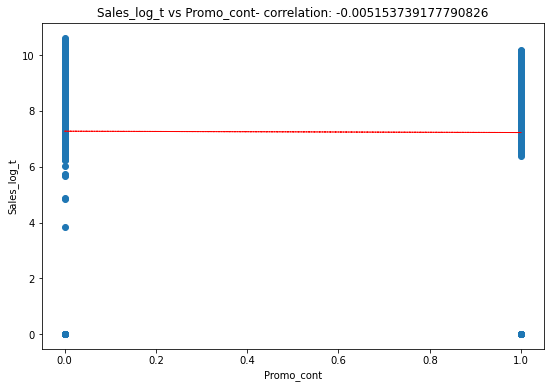

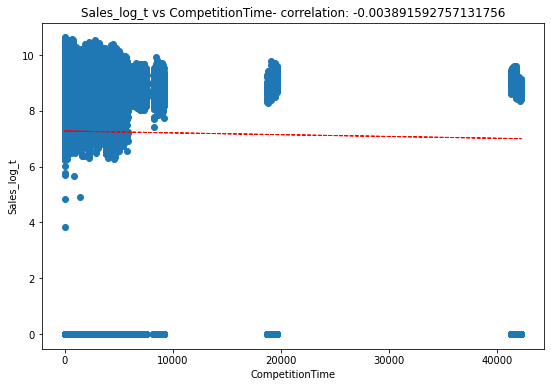

In [ ]:
for col in sales_df:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = sales_df[col]
    label = sales_df['Sales_log_t']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Sales_log_t')
    ax.set_title('Sales_log_t vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(sales_df[col], sales_df['Sales_log_t'], 1)
    y_hat = np.poly1d(z)(sales_df[col])

    plt.plot(sales_df[col], y_hat, "r--", lw=1)

plt.show()

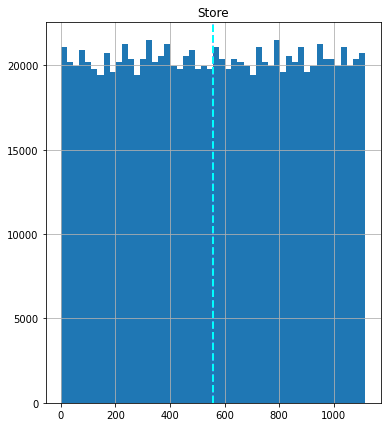

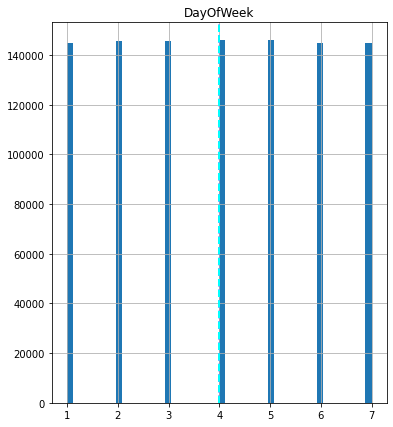

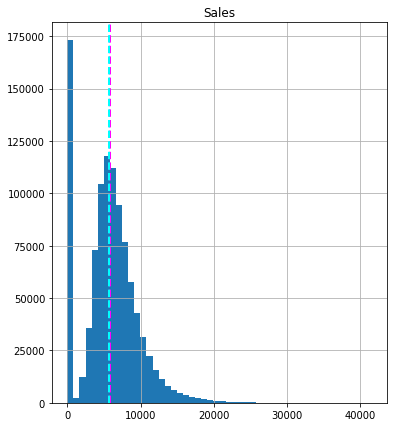

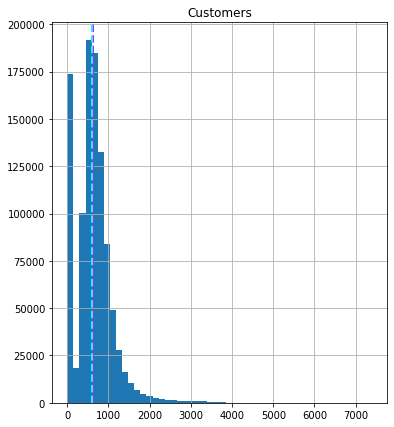

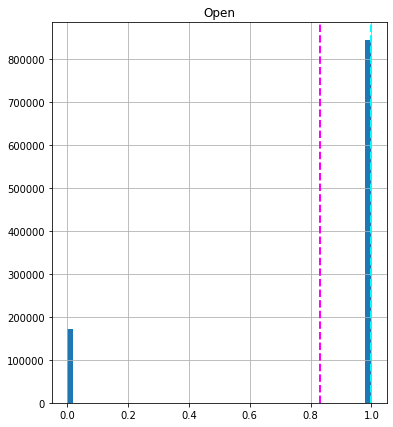

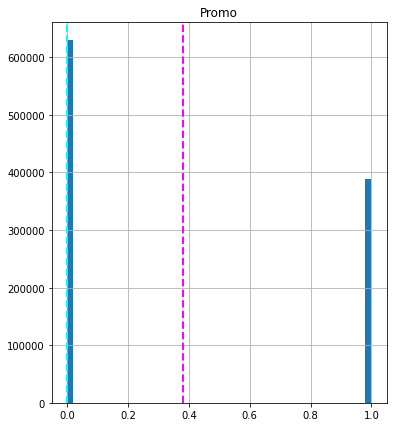

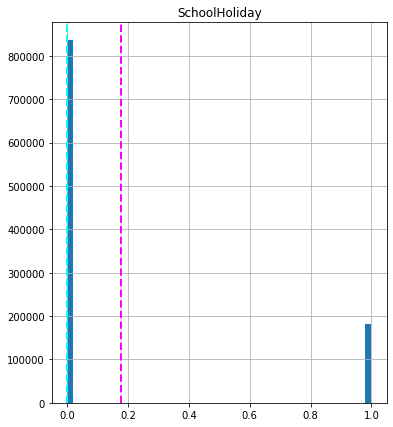

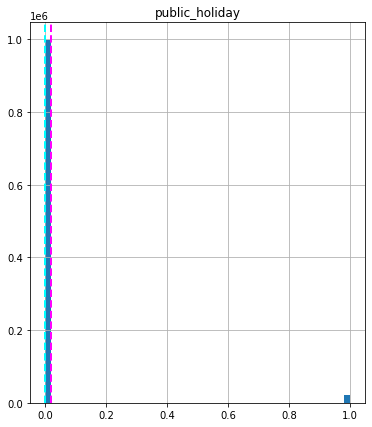

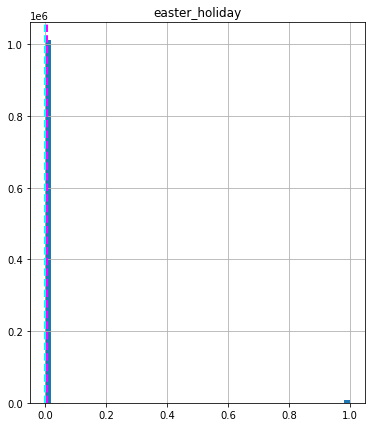

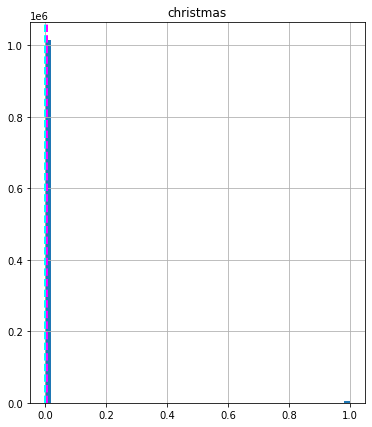

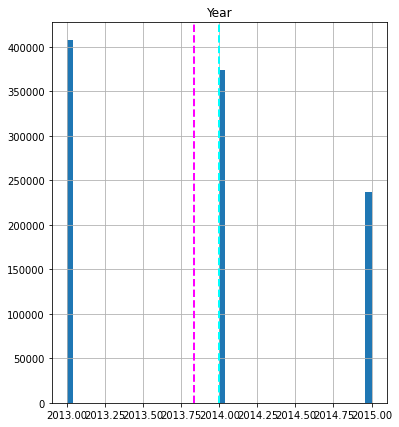

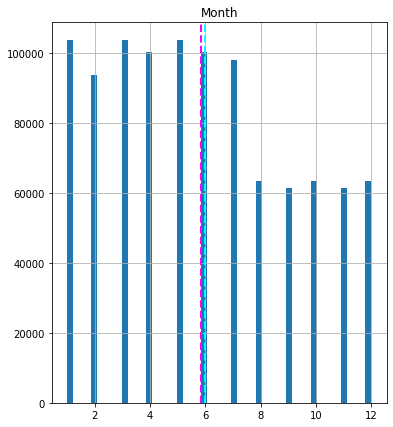

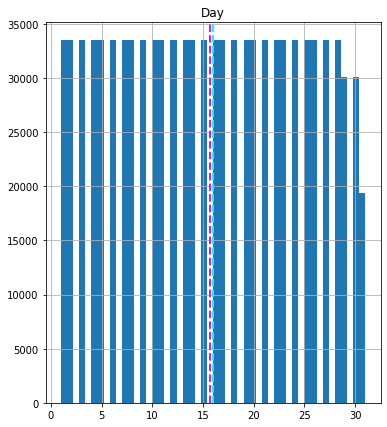

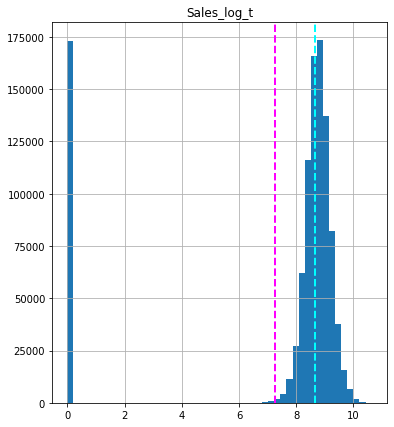

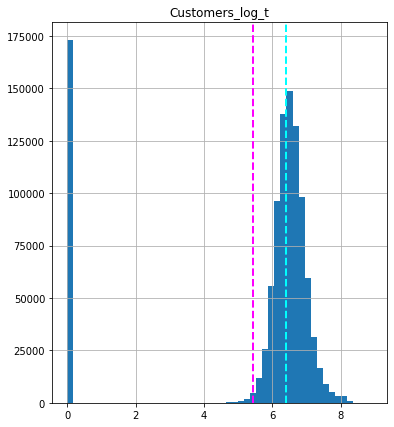

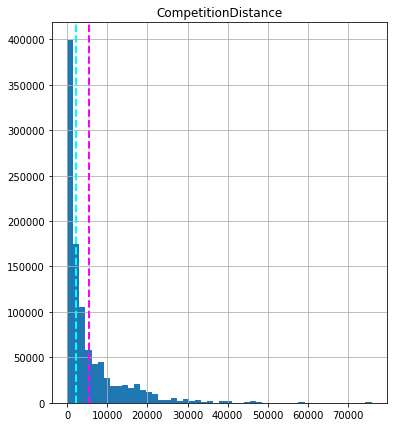

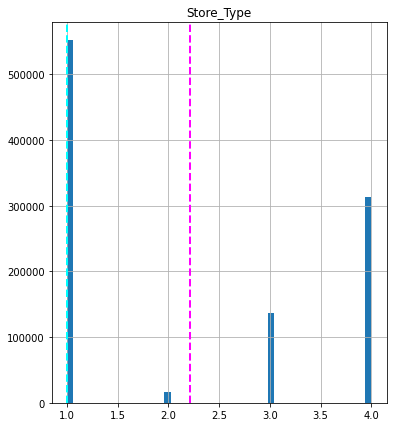

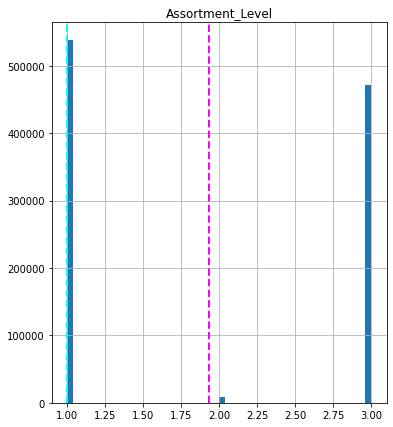

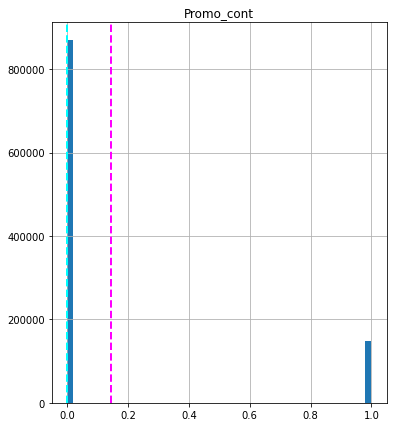

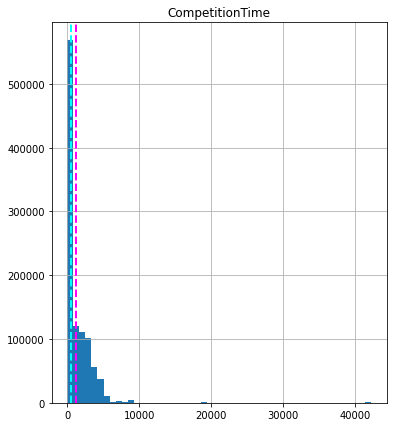

In [ ]:
for col in sales_df:
  figure=plt.figure(figsize=(6,7))
  ax=figure.gca()
  feature = sales_df[col]
  feature.hist(bins=50, ax = ax)
  ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
  ax.set_title(col)
plt.show()

We can see that there is a high correlation between some variables. We need to remove this multicollinearity.